# Screening task: Optimization -- Bin Packing Problem
*By: Juan Javier Naranjo Navarrete*

## 1. From Integer Linear Programming (ILP) to Quadratic Unconstrained Binary Optimization (QUBO)

### 1.1 Defining the ILP formulation of the BPP with Docplex.
Definition extracted from: Martello, S., Marconi, D. E. I. G., Mater, A., & Universit, S. (n.d.). Bin packing problems. 0–50.

**Problem description:** given $n$ items, each having an integer weight (or size) $\omega_{j}$, $j=1,2,...,n$ and an unlimited number of identical bins of integer capacity $B$. **Pack all the items into the minimum number of bins so that the total weight packed in any bin does not exceed the capacity**. Consider $0<\omega_j<B$ for all $j$.

Model:

\begin{eqnarray}
    min\:K &=& \sum_{i=1}^{m}y_{i}\\
    constrained\:to &:& \\
    \sum_{j=1}^{n}\omega_{j}x_{ij} &\leq& By_{i} \hspace{1.8cm} i=1,...,m\\
    \sum_{i=1}^{m}x_{ij} &=& 1 \hspace{2.3cm} j=1,...,n\\
    y_{i}&\in&\{0,1\} \hspace{1.5cm} i=1,...,m\\
    x_{ij}&\in&\{0,1\} \hspace{1.5cm} i=1,...,m\: ; \: j = 1,...,n
\end{eqnarray}

In the model, $y_{i}=1$ if bin $i$ is used and $x_{ij}=1$ if item $j$ is packed in bin $i$. Let $n=m$ since, in the worst scenario, each item is packed in only one bin.

In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
import numpy as np
import matplotlib.pyplot as plt

Let's create a function with inputs:

- **num_items:** total number of items to be packed.
- **weigths_of_items:** an ordered list or dictionary containing the weigths of each item. An example is shown in 1.3.
- **bin_capacity:** an integer capacity for the bins.

The function returns the ILP model with the proper constrains.

In [2]:
def BPP_as_ILP(num_items, weigths_of_items, bin_capacity, print_model = False):
    #check dimensions
    assert num_items == len(weigths_of_items), "Number of items is not equal to the dimension of the vector of weights"

    #to dict
    if type(weigths_of_items) is list:
        weigths_of_items = {f"w{i}":weigths_of_items[i] for i in range(num_items)}

    #check assumptions
    assert bin_capacity > max(weigths_of_items.values()), "Item's weigth equal or bigger than bin capacity"
    assert all(x > 0 for x in weigths_of_items.values()), "Item's weigth equal or lower than zero"
        
    #define QuadraticProgram instance
    model = QuadraticProgram()
    
    #define x and y as binary variables
    for i in range(num_items):
        model.binary_var(f"y{i}")
        for j in range(num_items):
            model.binary_var(f"x{i}{j}")
    
    #add constrains
    for i in range(num_items):
        model.linear_constraint(linear = {**{f"x{i}{j}" : weigths_of_items[f"w{j}"] for j in range(num_items)},**{f"y{i}":-bin_capacity}},
                                sense = "<=",
                                rhs = 0,
                                name = f"B{i} constrain")
        model.linear_constraint(linear = {f"x{j}{i}" : 1 for j in range(num_items)},
                                sense = "==", 
                                rhs = 1, 
                                name = f"Sum {i} in x")
    
    #add funciton to minimize
    model.minimize(linear = {f"y{i}" : 1 for i in range(num_items)})

    if print_model:
        print(model.prettyprint())

    return model

### 1.2 Create a function to transform the ILP model into QUBO

In [5]:
from qiskit_optimization.converters import QuadraticProgramToQubo

We know that the BPP has an inequality and an equity as constrains. The inequity needs to be converted into a equity constrain and all variables must be binary. With **QuadraticProgramToQubo**, conversion is direct (it uses slack variables). The following function takes as input the ILP model obtained as output from the function in 1.1.

In [7]:
def convert_ILP_to_QUBO(model, print_model = False):
    qubo = QuadraticProgramToQubo().convert(model)

    if print_model:
        print(qubo.prettyprint())
        
    return qubo

### 1.3 Test with specific instances

Let's define a dictionary that contains the general sizes of the items. Now, we can have randomly selected a group of **n** items with weigths. We also need to define the bin capacity **B**.

In [9]:
#define dictionary of sizes
sizes = {"small" : 1,
        "medium" : 2,
        "big" : 3}

#number of items
n = 3

#bin capacity
B = 5

#define weigths of items, randomly or arbitrarly, as list or dict
w = {f"w{j}" : np.random.choice(list(sizes.values()),1)[0] for j in range(n)}
#w = [2,3,0,4]
print(f"Weigths : {w} \n")

print("BPP as ILP")
ilp_model = BPP_as_ILP(num_items = n,
                      weigths_of_items = w,
                      bin_capacity = B,
                      print_model = True)

print("\nBPP as QUBO")
qubo_model = convert_ILP_to_QUBO(ilp_model,
                                print_model = True)

Weigths : {'w0': 2, 'w1': 3, 'w2': 1} 

BPP as ILP
Problem name: 

Minimize
  y0 + y1 + y2

Subject to
  Linear constraints (6)
    2*x00 + 3*x01 + x02 - 5*y0 <= 0  'B0 constrain'
    x00 + x10 + x20 == 1  'Sum 0 in x'
    2*x10 + 3*x11 + x12 - 5*y1 <= 0  'B1 constrain'
    x01 + x11 + x21 == 1  'Sum 1 in x'
    2*x20 + 3*x21 + x22 - 5*y2 <= 0  'B2 constrain'
    x02 + x12 + x22 == 1  'Sum 2 in x'

  Binary variables (12)
    y0 x00 x01 x02 y1 x10 x11 x12 y2 x20 x21 x22


BPP as QUBO
Problem name: 

Minimize
  4*B0 constrain@int_slack@0^2
  + 16*B0 constrain@int_slack@0*B0 constrain@int_slack@1
  + 16*B0 constrain@int_slack@0*B0 constrain@int_slack@2
  + 16*B0 constrain@int_slack@1^2
  + 32*B0 constrain@int_slack@1*B0 constrain@int_slack@2
  + 16*B0 constrain@int_slack@2^2 + 4*B1 constrain@int_slack@0^2
  + 16*B1 constrain@int_slack@0*B1 constrain@int_slack@1
  + 16*B1 constrain@int_slack@0*B1 constrain@int_slack@2
  + 16*B1 constrain@int_slack@1^2
  + 32*B1 constrain@int_slack@1*B1 co

## 2. Create a Brute Force solver for the QUBO problem and solve the specific instances.

In [11]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from itertools import combinations_with_replacement

In [13]:
# define the solver to have the exact solution
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())

In [28]:
# define the model
sizes = {"small" : 1,
        "medium" : 2,
        "big" : 3}
n = 3
B = 4

w = {f"w{j}" : np.random.choice(list(sizes.values()),1)[0] for j in range(n)}

ilp_model = BPP_as_ILP(num_items = n,
                      weigths_of_items = w,
                      bin_capacity = B)

qubo_model = convert_ILP_to_QUBO(ilp_model)

The Brute-Force method is just try all possible answers until the objective function is satisfied. In our case, even just solving for 3 items would require evaluating $2^{21}$ binary strings because the model has 21 binary variables. However, not all solutions are valid. To simplify, we will ignore solutions where $y_i=0$ but $x_{ij}=1$ for the same $i$. The function below provides all valid solutions.

In [15]:
def get_possible_answers(QuadProgram, n, print_lengths = False):
    possible_bitstrings = [[0]*(n+1)] #empty bin
    
    for bitstring in [bin(j)[2::].zfill(n) for j in range(2**n)]: #for every possible bitstring with length n
        possible_bitstrings.append([1] + list(map(int,list(bitstring))))
    
    possible_bitstrings = list(combinations_with_replacement(possible_bitstrings,n)) # get combination of all possible bitstrings
    possible_bitstrings = list(map(lambda x: np.array(x).reshape(-1), possible_bitstrings)) # flat the bit-array
    
    n_slack = len(QuadProgram.variables) - (n+1)*n #number of slack variables
    slack_bin_vars = [list(bin(j)[2::].zfill(n_slack)) for j in range(2**n_slack)] #generate every possible bitstring of length n_slack
    slack_bin_vars = list(map(lambda x: list(map(int,x)), slack_bin_vars)) # transform to list
    
    possible_answers = []
    
    for pb in possible_bitstrings:
        for sbv in slack_bin_vars:
            possible_answers.append(np.concatenate((pb,np.array(sbv)))) # join possible bitstrings 

    if print_lengths:
        print("Number of possible bitstrings for y/x variables:", len(possible_bitstrings))
        print("Number of possible bitstrings for slack variables:", len(slack_bin_vars))
        print("Number of possible bitstrings for answers:", len(possible_answers))
    
    return possible_answers

The following function helps to clarify a bitstring solution for the BPP.

In [9]:
def interpret_solution(n, weigths_of_items,solution):
    #to dict
    if type(weigths_of_items) is list:
        weigths_of_items = {f"w{i}":weigths_of_items[i] for i in range(n)}
    
    solution = solution[:(n*(n+1))].reshape(n,-1)
    for num_bin, bin in enumerate(solution):
        if bin[0]:
            print(f"Bin {num_bin} is used by items:")
            for num_item, item in enumerate(bin[1:]):
                if item:
                    item_str = f"w{num_item}"
                    print(f"{item_str} -- size: {weigths_of_items[item_str]}")
        else:
            print(f"Bin {num_bin} is not used.")

        print("\n")

Now, we find all possible answers for the 3-item problem. Then, we evaluate them in the objective function; its value is called **cost**. We keep the bitstring with the lowest cost.

In [30]:
possible_answers = get_possible_answers(qubo_model,n,print_lengths=True)

Number of possible bitstrings for y/x variables: 165
Number of possible bitstrings for slack variables: 512
Number of possible bitstrings for answers: 84480


In [31]:
cost = 100
solution = []

for pa in possible_answers:
    new_cost = qubo_model.objective.evaluate(pa)
    if new_cost < cost:
        cost = new_cost
        solution = pa

print("Cost:", cost)
print("Solution:", solution)

Cost: 1.0
Solution: [0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0]


In [34]:
interpret_solution(n, w, solution)

Bin 0 is not used.


Bin 1 is not used.


Bin 2 is used by items:
w0 -- size: 1
w1 -- size: 1
w2 -- size: 2




We can check the brute-force solution with the exact solution.

In [36]:
result = exact.solve(qubo_model)
interpret_solution(n, w, result.samples[0].x)

Bin 0 is not used.


Bin 1 is not used.


Bin 2 is used by items:
w0 -- size: 1
w1 -- size: 1
w2 -- size: 2




In this case, the answers are the same! I've tried only with 3 items since its computational time is reasonable. The 4-item problem took +25 minutes to compute an answer (Intel I7 - 7th Gen, 16 GB RAM).

## 3. Quantum Annealing Simulators to solve the QUBO.

Let's use a classical algorithm that simulate annealing. At the end, the result is a state vector with specific energy that aims to be the minimum. We'll use the **SimulatedAnnealingSampler** as sampler for a $n=10$ problem.

In [9]:
from dimod.binary import BinaryQuadraticModel
from dwave.samplers import SimulatedAnnealingSampler

In [10]:
sampler = SimulatedAnnealingSampler()

In [193]:
#define dictionary of sizes
sizes = {"small" : 1,
        "medium" : 2,
        "big" : 3}

#number of items
n = 10

#bin capacity
B = 4

#define weigths of items, randomly or arbitrarly, as list or dict
w = {f"w{j}" : np.random.choice(list(sizes.values()),1)[0] for j in range(n)}
#w = [2,2,2,2,2,4]

print(f"Weigths : {w} \n")

#print("BPP as ILP")
ilp_model = BPP_as_ILP(num_items = n,
                      weigths_of_items = w,
                      bin_capacity = B)

#print("\nBPP as QUBO")
qubo_model = convert_ILP_to_QUBO(ilp_model)

# define a Binary Quadratic Model suitable for D-Wave's SimulatedAnnealingSampler 
dwave_qubo = BinaryQuadraticModel(qubo_model.objective.linear.to_dict(),
                                  qubo_model.objective.quadratic.to_dict(),
                                  qubo_model.objective.constant,
                                  'BINARY')

samplerset = sampler.sample(dwave_qubo, num_reads = 1000)

Weigths : {'w0': 3, 'w1': 1, 'w2': 3, 'w3': 2, 'w4': 2, 'w5': 2, 'w6': 2, 'w7': 1, 'w8': 3, 'w9': 2} 



Now, **samplerset** contains **num_reads** state vectors with their energy. Our solution is the one with the lowest energy. Let's see how the number of bins depends on the energy/cost of the solution.

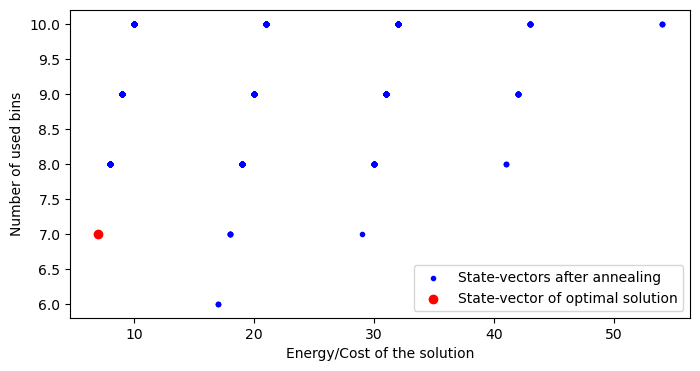

In [194]:
fig, ax = plt.subplots(figsize = (8,4))

bins_used = []
energies = []

for solution, energy, _ in samplerset.record:
    solution = np.array(solution)[:n*(n+1)].reshape(n,-1)
    bins_used.append(sum(solution[:,0]))
    energies.append(energy)

ax.scatter(energies, bins_used, color = 'b', marker = '.', label = 'State-vectors after annealing')

solution = list(samplerset.first.sample.values())
solution = np.array(solution)[:n*(n+1)].reshape(n,-1)
energies = samplerset.first.energy

ax.scatter([sum(solution[:,0])], [energies], color = 'r', marker = 'o', label = 'State-vector of optimal solution')
#ax.set_title(f'Items : {w} \n Bin Capacity : {B}')
ax.set_ylabel('Number of used bins')
ax.set_xlabel('Energy/Cost of the solution')

plt.legend(loc = 'lower right')
plt.show()

We see that a pattern emerges, but our aim it to find the solution with the lowest energy.

Another interesting feature that we might have a degenerated ground state (minimum energy state), which means that more than one state vector have the same minimum energy. This degenerated solutions corresponds to the different solutions to our problem, but all must be equivalent. Let's see what we got with the $x_{ij}$ matrix that contains the information of which items are stored in each bin.

In [196]:
possible_solutions = list(filter(lambda x: x[1]==samplerset.first.energy,samplerset.record))
print("Minimum energy:", samplerset.first.energy)
print("Number of vectors with minimum energy:", len(possible_solutions))

Minimum energy: 7.0
Number of vectors with minimum energy: 11


Items :  {'w0': 3, 'w1': 1, 'w2': 3, 'w3': 2, 'w4': 2, 'w5': 2, 'w6': 2, 'w7': 1, 'w8': 3, 'w9': 2}


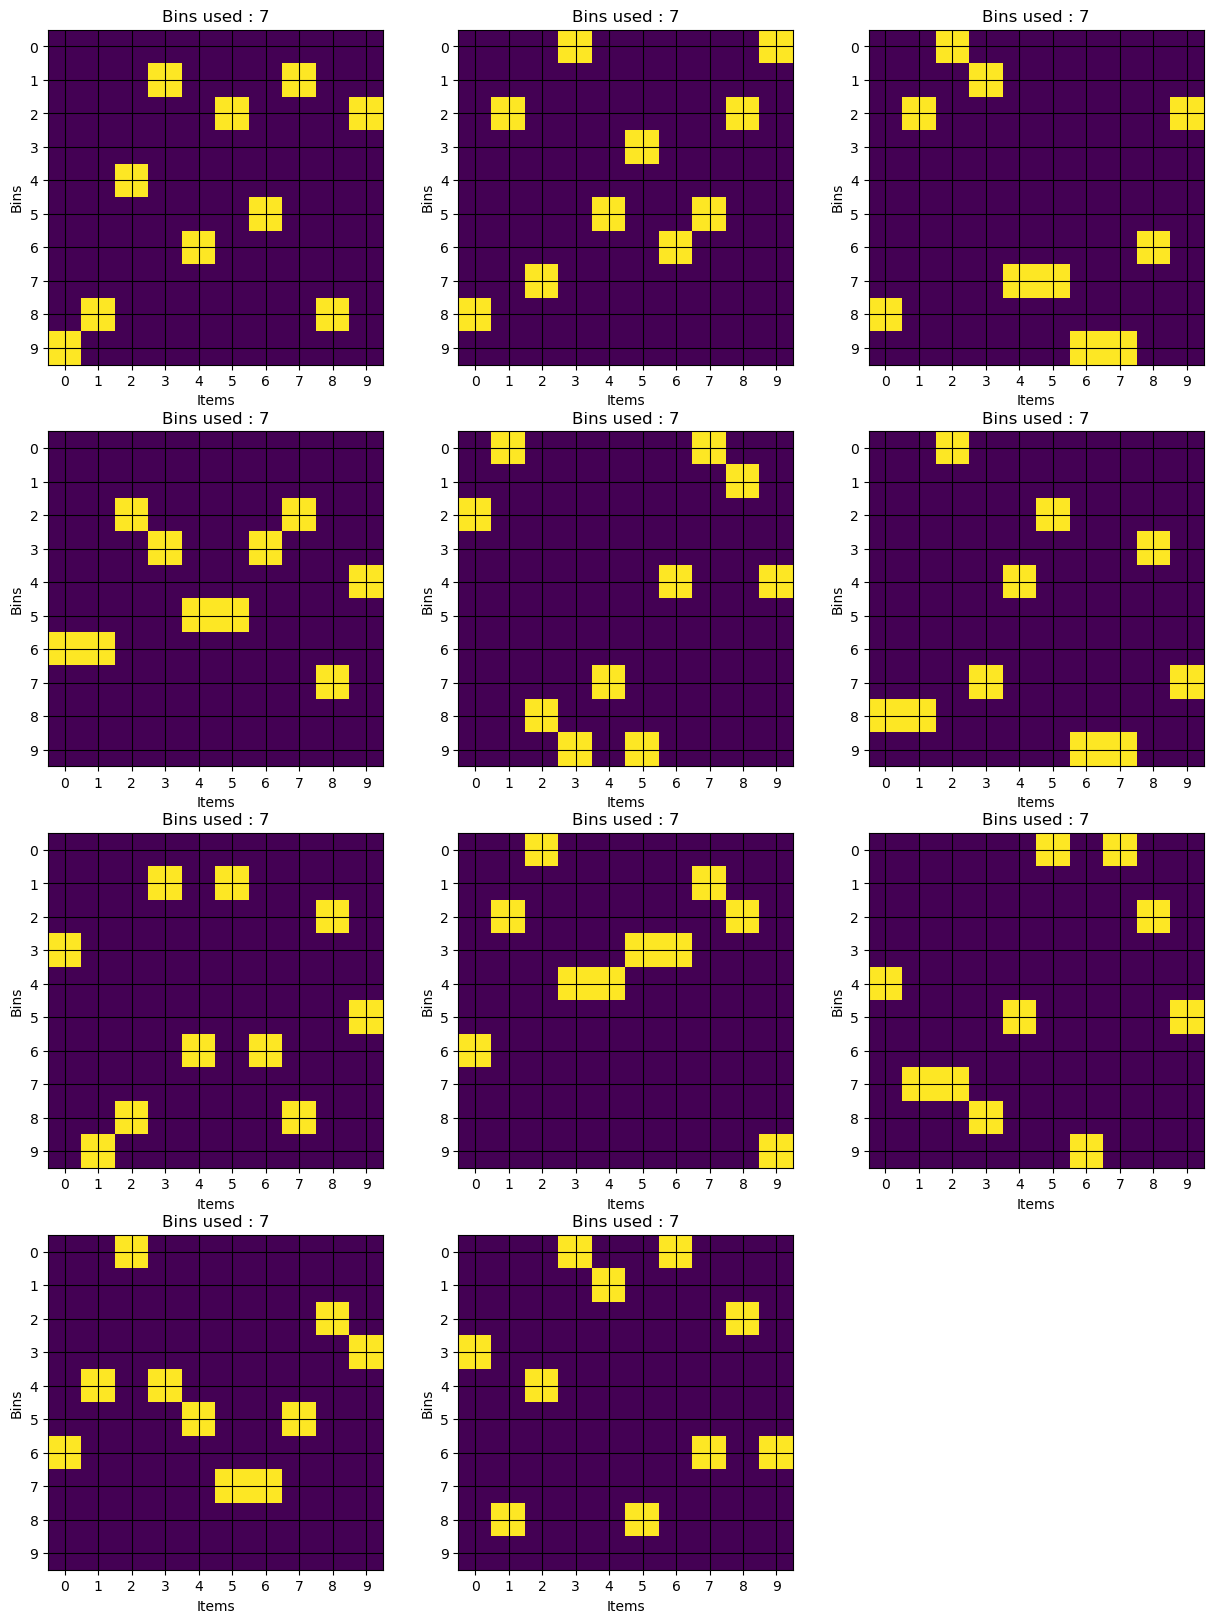

In [199]:
print('Items : ', w)

fig, axs = plt.subplots(nrows = (len(possible_solutions) + 2)//3, ncols = 3, figsize = (15, 5 * ((len(possible_solutions) + 2)//3)))

axs_flat = axs.flatten()

for i in range(len(possible_solutions), ((len(possible_solutions) + 2)//3) * 3):
    fig.delaxes(axs_flat[i])

for i,(solution,_,_) in enumerate(possible_solutions):
    solution = np.array(solution)[:n*(n+1)].reshape(n,-1)
    axs_flat[i].set_title(f"Bins used : {sum(solution[::,0])}")
    solution = solution[::,1:]
    axs_flat[i].imshow(solution)
    axs_flat[i].set_xticks(range(n))
    axs_flat[i].set_yticks(range(n))
    axs_flat[i].set_xlabel('Items')
    axs_flat[i].set_ylabel('Bins')
    axs_flat[i].grid(color = 'k')

plt.show()

We're also interested in the time that took to the simulator to compute the answer, This will depend on the number of binary variables and the number of repetitions (num_reads). Let's set **num_reads** to 1000 and see how the time varies with the number of variables.

In [354]:
sizes = {"small" : 1,
        "medium" : 2,
        "big" : 3}

B = 4

num_variables = []
data_time_mean = []

for n_var in range(2,11):
    data_time = []
    for i in range(10): #repeat each one 10 times for diferent items
        w = {f"w{j}" : np.random.choice(list(sizes.values()),1)[0] for j in range(n_var)}
        
        ilp_model = BPP_as_ILP(num_items = n_var,
                              weigths_of_items = w,
                              bin_capacity = B)
        
        qubo_model = convert_ILP_to_QUBO(ilp_model)
        
        dwave_qubo = BinaryQuadraticModel(qubo_model.objective.linear.to_dict(),
                                          qubo_model.objective.quadratic.to_dict(),
                                          qubo_model.objective.constant,
                                          'BINARY')
        
        samplerset = sampler.sample(dwave_qubo, num_reads = 1000)

        data_time.append(list(samplerset.info['timing'].values()))

    data_time = np.array(data_time)
    data_time_mean.append(np.mean(data_time,0))
    num_variables.append(len(samplerset.variables))

data_time_mean = np.array(data_time_mean)

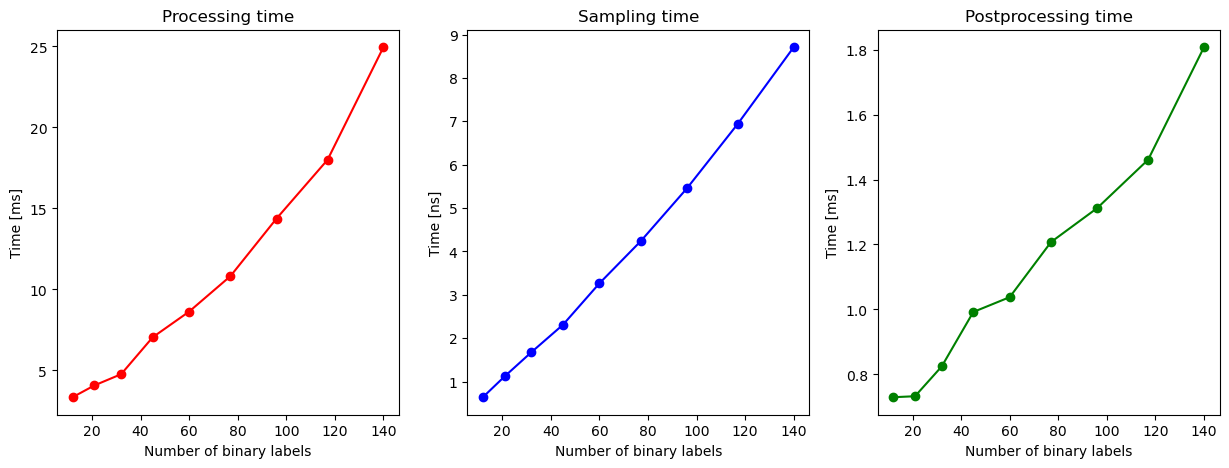

In [363]:
fig, (ax1,ax2,ax3) = plt.subplots(ncols = 3, figsize = (15,5))

ax1.plot(num_variables, (1e-6)*data_time_mean[:,0], color = 'r', marker = 'o')
ax2.plot(num_variables, (1e-9)*data_time_mean[:,1], color = 'b', marker = 'o')
ax3.plot(num_variables, (1e-6)*data_time_mean[:,2], color = 'g', marker = 'o')

for ax, (title, tu) in zip((ax1,ax2,ax3),(('Processing time','ms'),('Sampling time','ns'),('Postprocessing time','ms'))):
    ax.set_xlabel('Number of binary variables')
    ax.set_ylabel(f'Time [{tu}]')
    ax.set_title(title)

plt.show()

A quick scan of the results tells us that the processing and postprocessing time increases with the number of binary variables following a polynomic form, while the sampling time increases linearly.

## 4. Quantum Variational Approach to solve the QUBO

If you are running this notebook sequentially, it may be a good idea to restart the kernel, so we can have a better performance. The modules and functions we need for further tasks are below.

In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def BPP_as_ILP(num_items, weigths_of_items, bin_capacity, print_model = False):
    #check dimensions
    assert num_items == len(weigths_of_items), "Number of items is not equal to the dimension of the vector of weights"

    #to dict
    if type(weigths_of_items) is list:
        weigths_of_items = {f"w{i}":weigths_of_items[i] for i in range(num_items)}

    #check assumptions
    assert bin_capacity > max(weigths_of_items.values()), "Item's weigth equal or bigger than bin capacity"
    assert all(x > 0 for x in weigths_of_items.values()), "Item's weigth equal or lower than zero"
        
    #define QuadraticProgram instance
    model = QuadraticProgram()
    
    #define x and y as binary variables
    for i in range(num_items):
        model.binary_var(f"y{i}")
        for j in range(num_items):
            model.binary_var(f"x{i}{j}")
    
    #add constrains
    for i in range(num_items):
        model.linear_constraint(linear = {**{f"x{i}{j}" : weigths_of_items[f"w{j}"] for j in range(num_items)},**{f"y{i}":-bin_capacity}},
                                sense = "<=",
                                rhs = 0,
                                name = f"B{i} constrain")
        model.linear_constraint(linear = {f"x{j}{i}" : 1 for j in range(num_items)},
                                sense = "==", 
                                rhs = 1, 
                                name = f"Sum {i} in x")
    
    #add funciton to minimize
    model.minimize(linear = {f"y{i}" : 1 for i in range(num_items)})

    if print_model:
        print(model.prettyprint())

    return model

def convert_ILP_to_QUBO(model, print_model = False):
    qubo = QuadraticProgramToQubo().convert(model)

    if print_model:
        print(qubo.prettyprint())
        
    return qubo

def interpret_solution(n, weigths_of_items,solution):
    #to dict
    if type(weigths_of_items) is list:
        weigths_of_items = {f"w{i}":weigths_of_items[i] for i in range(n)}
    
    solution = solution[:(n*(n+1))].reshape(n,-1)
    for num_bin, bin in enumerate(solution):
        if bin[0]:
            print(f"Bin {num_bin} is used by items:")
            for num_item, item in enumerate(bin[1:]):
                if item:
                    item_str = f"w{num_item}"
                    print(f"{item_str} -- size: {weigths_of_items[item_str]}")
        else:
            print(f"Bin {num_bin} is not used.")

        print("\n")

Let's use Qiskit to solve our QUBO with a VQE. Qiskit has some prebuilt parametrized circuit that can serve as ansatze. Let's use **TwoLocal** and **EfficientSU2** circuits, so we can define the rotation and entanglement blocks, as well as the entanglement type. It's interesting to compare the results of different optimization methods, but, due to computational capability, let's just try **COBYLA** method. We begin with the import of functions and modules.

In [6]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator, SamplerV2 as Sampler
from qiskit_aer import AerSimulator
from scipy.optimize import minimize

Since the simulators hardly handle circuits with +25 qubits, let's solve the BPP with 3 items, which needs 21 qubits.

In [8]:
#define dictionary of sizes
sizes = {"small" : 1,
        "medium" : 2,
        "big" : 3}

#number of items
n = 3

#bin capacity
B = 4

#define weigths of items, randomly or arbitrarly, as list or dict
#w = {f"w{j}" : np.random.choice(list(sizes.values()),1)[0] for j in range(n)}
w = [1,2,3]

print(f"Weigths : {w} \n")

qubo_model = convert_ILP_to_QUBO(BPP_as_ILP(num_items = n, weigths_of_items = w, bin_capacity = B))

Weigths : [1, 2, 3] 



Now, we define a function with 2 arguments: the QUBO and the ansatz. Quick explanations of the function are commented inside. 

In [11]:
def VQE_for_BPP(qubo, ansatz):
    #define a cost_function which constructs and evaluate the ansatz
    # with some parameters and returns the expectation value of the hamiltonian obtained from the QUBO
    def cost_func(params, in_ansatz, hamiltonian, estimator, callback_dict):
        pub = (in_ansatz, [hamiltonian], [params])
        result = estimator.run([pub]).result()
        energy = result[0].data.evs[0]
    
        callback_dict["iters"] += 1
        callback_dict["prev_vector"] = params
        callback_dict["cost_history"].append(energy)
        return energy, result
        
    #a function compatible with scipy's minimize function
    def cost_func_2(*args, **kwargs):
        energy, result = cost_func(*args, **kwargs)
        return energy

    backend = AerSimulator() # a backend for local simulations
    pm = generate_preset_pass_manager(backend = backend,
                                      optimization_level = 1) # a pass manager to make the circuit compatible with backend
    isa_circuit = pm.run(ansatz) # a circuit that obeys the backend's instruction set arquitecture (ISA)
    H = qubo.to_ising()[0].apply_layout(layout=isa_circuit.layout) # Ising hamiltonian from the QUBO and compatible with isa_circuit layout

    # a dictionary to store results
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    x0 = [np.pi/2]*ansatz.num_parameters # initial parameters
        
    res = minimize(
        cost_func_2,
        x0,
        args=(isa_circuit, H, Estimator(backend = backend), callback_dict),
        method="cobyla",
        options={'maxiter': 700}) # optimization step 

    ansatz.measure_all() #add classical registers and measurements to ansatzs circuit
    pm = generate_preset_pass_manager(backend = backend,
                                      optimization_level = 1)
    isa_circuit = pm.run(ansatz)
    sampler = Sampler(backend = backend) 

    job = sampler.run([(isa_circuit, callback_dict["prev_vector"], 10240)]) #run the circuit with best fit parameters
    result = job.result()
    solution = result[0].data.meas.get_counts()
    
    return callback_dict, solution

Let's define 4 ansatzs and compare their results.

In [13]:
ansatz_1 = TwoLocal(num_qubits = len(qubo_model.variables),
                 rotation_blocks = ["rx"], 
                 entanglement_blocks = ["cx"],
                 entanglement = "full",
                 reps = 1,
                 insert_barriers = True)

In [15]:
ansatz_2 = TwoLocal(num_qubits = len(qubo_model.variables),
                 rotation_blocks = ["rx","ry"], 
                 entanglement_blocks = ["cz"],
                 entanglement = "full",
                 reps = 1,
                 insert_barriers = True)

In [17]:
ansatz_3 = EfficientSU2(num_qubits = len(qubo_model.variables),
                 su2_gates = ["rx","ry"],
                 entanglement = "full",
                 reps = 1,
                 insert_barriers = True)

In [19]:
ansatz_4 = EfficientSU2(num_qubits = len(qubo_model.variables),
                 su2_gates = ["rx"],
                 entanglement = "circular",
                 reps = 1,
                 insert_barriers = True)

Now we use the function *VQE_for_BPP* to find the solution to our QUBO using **COBYLA** optimization method. We retrieve the cost/energy history and the output with more counts of the optimized ansatz.

In [37]:
res_all_ansatz = []
sol_all_ansatz = []

for an in (ansatz_1, ansatz_2, ansatz_3, ansatz_4,):
    res_energies, result = VQE_for_BPP(qubo = qubo_model,
                                       ansatz = an)
    max_counts = max(result, key = lambda x: result[x])
    res_all_ansatz.append(res_energies)
    sol_all_ansatz.append({max_counts : result[max_counts]})

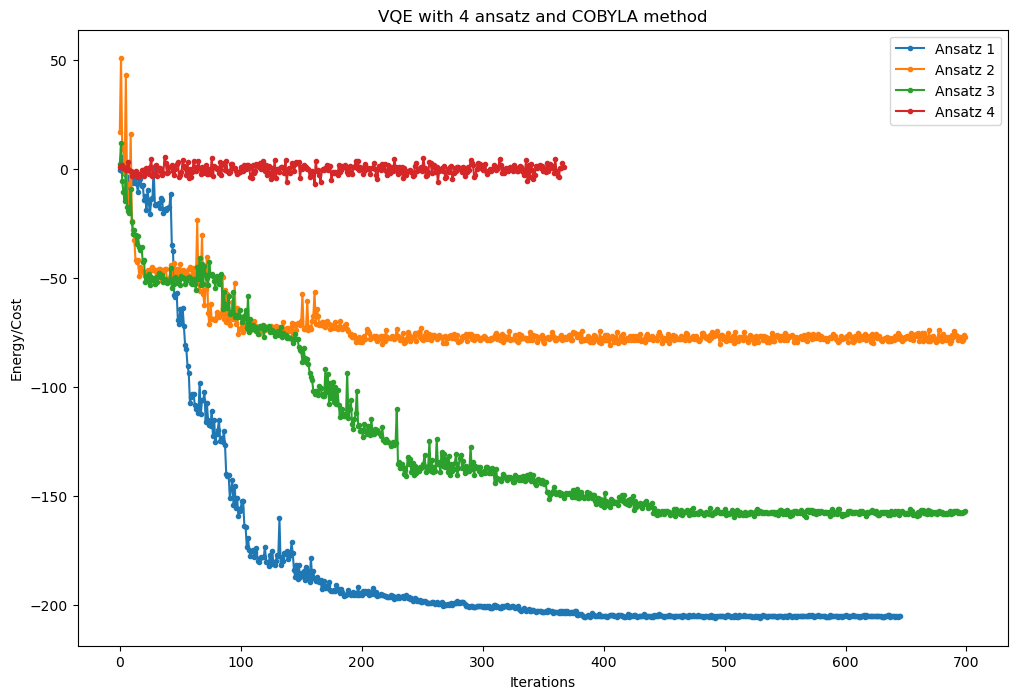

In [81]:
fig, ax = plt.subplots(figsize = (12,8))

for i, an in enumerate(res_all_ansatz):
    ax.plot(range(an["iters"]), an["cost_history"], marker = ".", ls = "-", label = f"Ansatz {i+1}")

ax.set_xlabel("Iterations")
ax.set_ylabel("Energy/Cost")
ax.set_title("VQE with 4 ansatz and COBYLA method")
plt.legend(loc = "upper right")
plt.show()

Now, let's interpret the solutions for the different ansatz.

In [83]:
for i,(bits,counts) in enumerate((list(x.items())[0] for x in sol_all_ansatz)):
    print(f"Ansatz {i+1} \t Counts : {counts}")
    print(f"Solution bitstring : {bits[::-1]}")
    bits = list(bits[::-1])
    bits = np.array(list(map(int,bits)))
    interpret_solution(n, w, bits)

Ansatz 1 	 Counts : 347
Solution bitstring : 100111001110001011100
Bin 0 is used by items:
w2 -- size: 3


Bin 1 is used by items:
w0 -- size: 1


Bin 2 is used by items:
w0 -- size: 1
w1 -- size: 2


Ansatz 2 	 Counts : 112
Solution bitstring : 101111011001111111111
Bin 0 is used by items:
w1 -- size: 2
w2 -- size: 3


Bin 1 is used by items:
w0 -- size: 1
w2 -- size: 3


Bin 2 is used by items:
w2 -- size: 3


Ansatz 3 	 Counts : 179
Solution bitstring : 110100101101010100100
Bin 0 is used by items:
w0 -- size: 1
w2 -- size: 3


Bin 1 is not used.


Bin 2 is used by items:
w0 -- size: 1
w2 -- size: 3


Ansatz 4 	 Counts : 2
Solution bitstring : 001011000010010000010
Bin 0 is not used.


Bin 1 is used by items:
w0 -- size: 1


Bin 2 is not used.




From the graphic we can say that the ansatz 1 performed the best, reaching the minimum energy from all four ansatze. However, none of the ansatze gave an appropiate answer. The solution from ansatz 1 may be the closer to an answet for our problem. This shows one big problem of the VQE method: we may reach a local minimum of the energy function if we don't choose good initial parameters and thus we not obtain the state that has the global minimum energy; and, if we would like to simulate more variables, we should do it in more powerful but classical simulators or in real quantum hardware. One way to improve our results is taking the output parameters from ansatz 1 and set them as initial parameters; we could increase the maximum iterations as well. But let's see the QAOA approach for the problem. 

## 5. QAOA for BPP 

Once again, if running this notebook sequentially, we may restart the kernel. Needed functions and modules to complete this task are below.

In [1]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.converters import QuadraticProgramToQubo
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def BPP_as_ILP(num_items, weigths_of_items, bin_capacity, print_model = False):
    #check dimensions
    assert num_items == len(weigths_of_items), "Number of items is not equal to the dimension of the vector of weights"

    #to dict
    if type(weigths_of_items) is list:
        weigths_of_items = {f"w{i}":weigths_of_items[i] for i in range(num_items)}

    #check assumptions
    assert bin_capacity > max(weigths_of_items.values()), "Item's weigth equal or bigger than bin capacity"
    assert all(x > 0 for x in weigths_of_items.values()), "Item's weigth equal or lower than zero"
        
    #define QuadraticProgram instance
    model = QuadraticProgram()
    
    #define x and y as binary variables
    for i in range(num_items):
        model.binary_var(f"y{i}")
        for j in range(num_items):
            model.binary_var(f"x{i}{j}")
    
    #add constrains
    for i in range(num_items):
        model.linear_constraint(linear = {**{f"x{i}{j}" : weigths_of_items[f"w{j}"] for j in range(num_items)},**{f"y{i}":-bin_capacity}},
                                sense = "<=",
                                rhs = 0,
                                name = f"B{i} constrain")
        model.linear_constraint(linear = {f"x{j}{i}" : 1 for j in range(num_items)},
                                sense = "==", 
                                rhs = 1, 
                                name = f"Sum {i} in x")
    
    #add funciton to minimize
    model.minimize(linear = {f"y{i}" : 1 for i in range(num_items)})

    if print_model:
        print(model.prettyprint())

    return model

def convert_ILP_to_QUBO(model, print_model = False):
    qubo = QuadraticProgramToQubo().convert(model)

    if print_model:
        print(qubo.prettyprint())
        
    return qubo

def interpret_solution(n, weigths_of_items,solution):
    #to dict
    if type(weigths_of_items) is list:
        weigths_of_items = {f"w{i}":weigths_of_items[i] for i in range(n)}
    
    solution = solution[:(n*(n+1))].reshape(n,-1)
    for num_bin, bin in enumerate(solution):
        if bin[0]:
            print(f"Bin {num_bin} is used by items:")
            for num_item, item in enumerate(bin[1:]):
                if item:
                    item_str = f"w{num_item}"
                    print(f"{item_str} -- size: {weigths_of_items[item_str]}")
        else:
            print(f"Bin {num_bin} is not used.")

        print("\n")

Let's use pennylane to build our QAOA function to solve the QUBO.

In [4]:
import pennylane as qml
from pennylane import numpy as pnp

Since pennylane's device "default.qubit" can't handle large circuits, let's try it with two QUBOS: 2 items and large bin capacity, and 2 items and short bin capacity. Let's also see how the energy varies.

In [8]:
n = 2
w = [2,2]

print(f"Weigths : {w} \n")

qubo_model_large_B = convert_ILP_to_QUBO(BPP_as_ILP(num_items = n, 
                                                    weigths_of_items = w, 
                                                    bin_capacity = 6))
qubo_model_short_B = convert_ILP_to_QUBO(BPP_as_ILP(num_items = n, 
                                                    weigths_of_items = w, 
                                                    bin_capacity = 3))

Weigths : [2, 2] 



The function below takes as inputs the number of items and the QUBO; it may also take an array for initial parameters and a really small number for the stop criteria, but both are optional. The function returns the optimal parameters, the energy history and the solution for the QUBO. Quick explanations of the code are commented. Here, the optimizer is **AdamOptimizer**, a gradient-descent optimizer with adaptative step-size, and I included a code that only take the next optimal parameters only if the energy is lower than the previous.

In [11]:
def QAOA_for_BPP(n, qubo, init_params = None, stop_criteria = 1e-6):
    tot_wires = range(len(qubo.variables)) # define number of wires/qubits
    H = qml.from_qiskit_op(qubo.to_ising()[0]) # hamiltonian operator from the QUBO

    # the circuit that contains the QAOA, here, I used a X gate mixer hamiltonian
    def qaoa_circuit(params, wires, hamiltonian):
        for w in wires:
            qml.Hadamard(wires = w)

        for alpha,beta in params:
            qml.qaoa.cost_layer(alpha, hamiltonian)
            qml.qaoa.mixer_layer(beta, qml.qaoa.x_mixer(wires = wires))

    device = qml.device("default.qubit", wires = len(tot_wires)) 
    
    @qml.qnode(device)
    def qaoa_expval(params, wires, hamiltonian): # get the expectation value of the hamilotnian i.e. the cost/energy
        qaoa_circuit(params, wires, hamiltonian)
        return qml.expval(hamiltonian)

    @qml.qnode(device)
    def qaoa_probs(params, wires, hamiltonian): # circuit to with measurements to obtain the bitstring solution
        qaoa_circuit(params, wires, hamiltonian)
        return qml.probs()
        
    if init_params is None:
        init_params = pnp.array([[0.5, 0.5] for i in range(n)], requires_grad = True) #initial parameters
    else:
        assert np.shape(init_params) == (n,2), "Invalid shape for initial params, should be an array of shape (n,2)"
        init_params = pnp.array(init_params, requires_grad = True)
    
    # define the optimizer
    step_size = 0.01
    optimizer = qml.AdamOptimizer(stepsize = step_size)
    
    # initial and next step
    initial_value = qaoa_expval(init_params, tot_wires, H)
    next_params = optimizer.step(qaoa_expval, init_params, tot_wires, H)
    next_value = qaoa_expval(next_params[0], tot_wires, H)
    difference = next_value - initial_value
    
    # begin loop with stop criteria
    energy_history = [initial_value, next_value]
    count = 0
    while (abs(difference) >= stop_criteria) and (count < 1000):
        count = count + 1
        initial_value = next_value
        init_params = optimizer.step(qaoa_expval, next_params[0], tot_wires, H)
        next_value = qaoa_expval(init_params[0], tot_wires, H)
        difference = next_value - initial_value
        
        if next_value >= initial_value:
            step_size = step_size*0.95
            optimizer = qml.AdamOptimizer(stepsize = step_size)
        else:
            next_params = init_params

        energy_history.append(next_value)

    # get the bitstring solution 
    index = pnp.argmax(qaoa_probs(next_params[0], tot_wires, H)) 
    vector = pnp.zeros(len(qml.matrix(H)))
    vector[index] = 1
    
    return next_params[0], energy_history, vector

If run this function, a warning will pop up saying "ComplexWarning: Casting complex values to real discards the imaginary part" because we might have complex values at our function that calculates the expectation value *qaoa_expval*. Since this is a real number, imaginary values are discarted. Even if the imaginary coefficient is zero the output needs to be a float-type number. So, the code in the cell bellow ignores this warning and prevents our screen to get filled with this warning.

In [14]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
opt_p_largeB, energy_largeB, solution_largeB = QAOA_for_BPP(n = n, qubo = qubo_model_large_B)
print("Now, the short QUBO")
opt_p_shortB, energy_shortB, solution_shortB = QAOA_for_BPP(n = n, qubo = qubo_model_short_B)

Now, the short QUBO


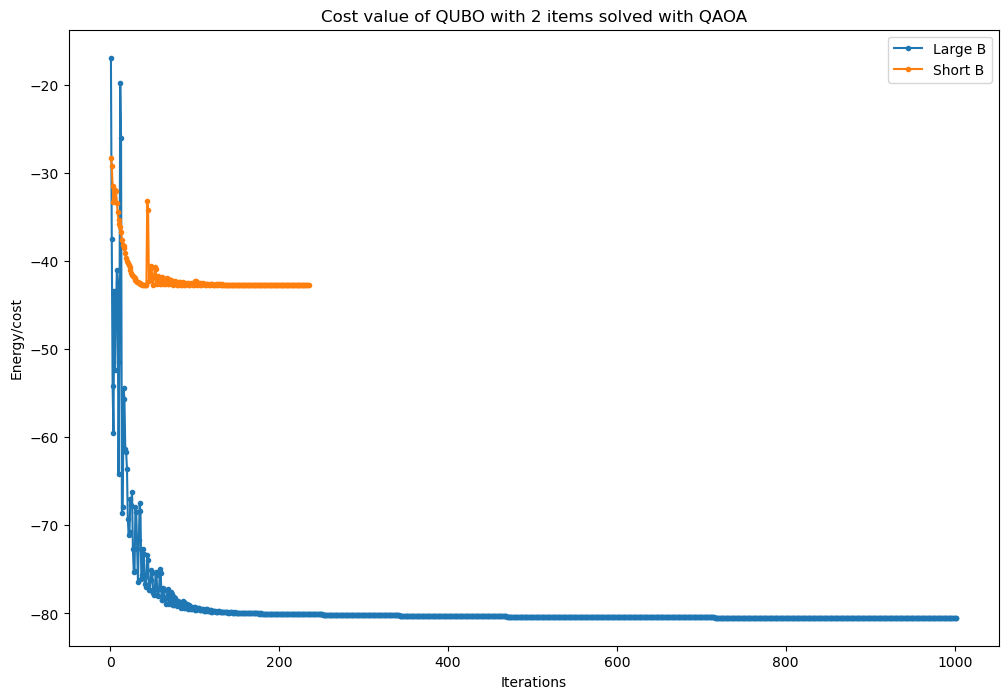

In [17]:
fig, ax = plt.subplots(figsize = (12,8))

ax.plot(range(1,len(energy_largeB)+1), energy_largeB, marker = ".", ls = "-", label = "Large B")
ax.plot(range(1,len(energy_shortB)+1), energy_shortB, marker = ".", ls = "-", label = "Short B")

ax.set_title("Cost value of QUBO with 2 items solved with QAOA")
ax.set_xlabel("Iterations")
ax.set_ylabel("Energy/cost")

plt.legend(loc = "upper right")
plt.show()

With the help of **Statevector** function from Qiskit, let's interpret our solution.

In [19]:
from qiskit.quantum_info import Statevector

In [20]:
for B, solution in zip(("Large B", "Short B"),(solution_largeB, solution_shortB)):
    print(f"Solution for {B} QUBO")
    bits = Statevector(np.array(solution)).to_dict()
    bits = list(bits.keys())[0]
    bits = np.array(list(map(int,bits)))
    interpret_solution(n,w,bits)

Solution for Large B QUBO
Bin 0 is used by items:
w1 -- size: 2


Bin 1 is used by items:
w0 -- size: 2


Solution for Short B QUBO
Bin 0 is used by items:
w0 -- size: 2


Bin 1 is used by items:
w1 -- size: 2




We can see that the solution for the short B QUBO is correct and the solution converged after few iterations, while the solution for the large B is not correct and it took all iterations possible. So, let's take random parameters as inputs and see if we can find another answer. 


Solution 1
Optimal parameters : [[0.86851664 0.76892336]
 [0.78964265 0.0645617 ]]
Interpreted solution :
Bin 0 is used by items:
w0 -- size: 2
w1 -- size: 2


Bin 1 is used by items:
w0 -- size: 2
w1 -- size: 2



Solution 2
Optimal parameters : [[0.87638286 1.2544621 ]
 [0.33581457 0.37548128]]
Interpreted solution :
Bin 0 is used by items:


Bin 1 is used by items:



Solution 3
Optimal parameters : [[0.61232374 0.02867914]
 [0.42917241 0.95175439]]
Interpreted solution :
Bin 0 is used by items:
w0 -- size: 2
w1 -- size: 2


Bin 1 is used by items:
w0 -- size: 2
w1 -- size: 2



Solution 4
Optimal parameters : [[0.34694595 0.369738  ]
 [0.04696684 0.49469513]]
Interpreted solution :
Bin 0 is used by items:
w0 -- size: 2
w1 -- size: 2


Bin 1 is used by items:
w0 -- size: 2
w1 -- size: 2



Solution 5
Optimal parameters : [[0.79516689 0.45887928]
 [0.18491445 0.66004507]]
Interpreted solution :
Bin 0 is not used.


Bin 1 is not used.



Solution 6
Optimal parameters : [[0.11747811 0

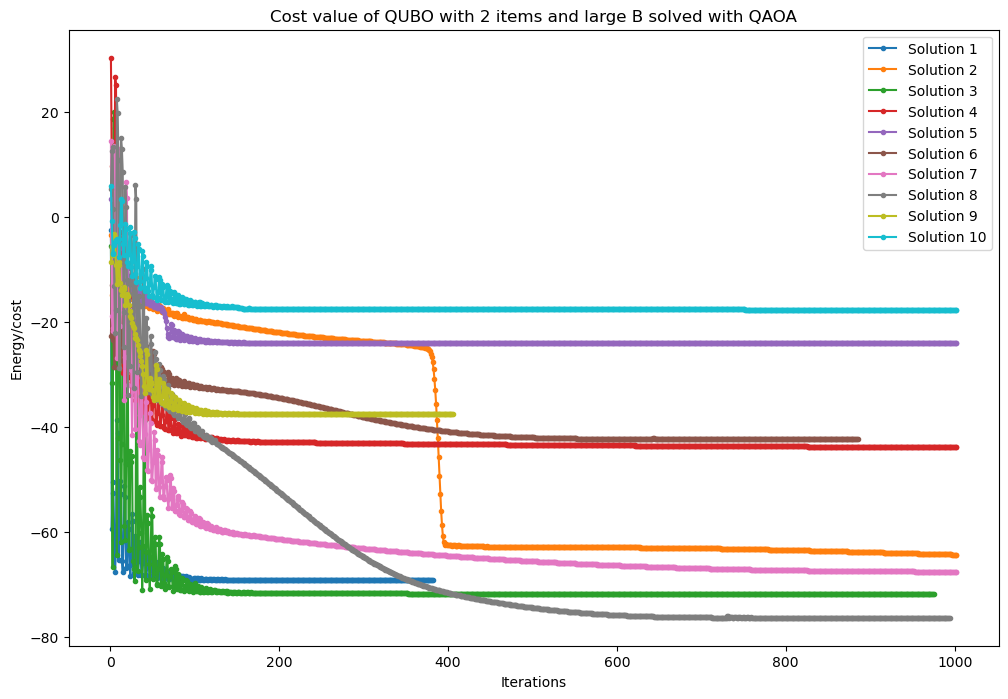

In [22]:
fig, ax = plt.subplots(figsize = (12,8))

for i in range(10):
    opt_p_largeB, energy_largeB, solution_largeB = QAOA_for_BPP(n = n, qubo = qubo_model_large_B,
                                                                init_params = np.random.rand(n,2),
                                                                stop_criteria = 1e-8)
    print(f"\nSolution {i+1}")
    print(f"Optimal parameters : {opt_p_largeB}")
    print("Interpreted solution :")
    bits = Statevector(np.array(solution_largeB)).to_dict()
    bits = list(bits.keys())[0]
    bits = np.array(list(map(int,bits)))
    interpret_solution(n,w,bits)

    ax.plot(range(1,len(energy_largeB)+1), energy_largeB, marker = ".", ls = "-", label = f"Solution {i+1}")

ax.set_title("Cost value of QUBO with 2 items and large B solved with QAOA")
ax.set_xlabel("Iterations")
ax.set_ylabel("Energy/cost")

plt.legend(loc = "upper right")
plt.show()

As we can see in the graphic, all the solutions converged to a different value of minimum energy. But in this case, the Solution 8 is the minimum for all and, in fact, gives the correct answer (Optimal parameters: [[-0.01046817  0.35596448], [ 0.15708948  0.06772128]]). This have helped us to see the high dependance of the answer on the initial parameters.

## 6. Analysis results and conclusions

The primary distinction between Quantum Annealing and Variational Quantum Eigensolver (VQE) / Quantum Approximate Optimization Algorithm (QAOA) lies in their methods for locating a minimum. Quantum Annealing operates by following the Schrödinger equation for time evolution, initializing in an equal superposition of all possible states. This allows it to naturally evolve into a minimum-energy state. By performing a rapid (diabatic) adjustment, Quantum Annealing can explore nearby states and, with a high probability, converge to the ground state with the global minimum energy.

In contrast, VQE and QAOA depend on parametrized, gate-based quantum computing. VQE additionally relies on the choice of an ansatz. Thus, implementing these methods requires careful selection of both the ansatz (in the case of VQE) and the initial parameters for optimization. As a result, more computational resources and time are needed to develop a circuit or parameter set that maximizes performance. However, these methods also face challenges: VQE or QAOA may yield a state with a high probability of the correct answer but still in superposition with other states. Due to the probabilistic nature of quantum measurement, we might observe an incorrect state, necessitating multiple attempts to obtain the desired solution. Additionally, these methods encounter limitations in classical simulation capacity. Simulating large quantum circuits (+20 qubits) is challenging for classical hardware, making it impractical for systems like a typical laptop to handle large models such as a 10-item BPP.

In a hypothetical scenario where we have access to a massive classical computing system, such as a supercomputer, solving a BPP with a few items might be feasible. We’ve observed that the QAOA on a classical simulator (like "default.qubit" in PennyLane) struggled with even a 3-item BPP, while a brute-force approach managed it in a "reasonable" time. However, as problem sizes grow, other approaches are essential for handling large optimization tasks.

If quantum hardware is available, VQE and QAOA present viable options, provided we can optimize the ansatz and initial parameters beforehand. Nevertheless, Quantum Annealing stands out as a particularly effective method for large-scale optimization. For instance, D-Wave offers quantum computers with thousands of qubits (e.g., 2000 and 5000), positioning them as highly suitable for tackling optimization problems efficiently. Hence, Quantum Annealing with D-Wave hardware may be one of the most practical and powerful options for solving large optimization models.